In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import qolmat

In [157]:
df_1 = pd.read_csv('Data/train.csv')

In [158]:
df_1.head()

,id,valeur_NO2,valeur_CO,valeur_O3,valeur_PM10,valeur_PM25
0,2020-01-01 00,42.9,0.718,15.7,73.1,64.4
1,2020-01-01 01,33.6,0.587,10.1,74.8,66.0
2,2020-01-01 02,29.3,NaN,5.1,51.0,44.9
3,2020-01-01 03,30.5,0.246,7.2,27.7,25.1
4,2020-01-01 04,29.3,0.204,8.3,15.3,13.6


In [159]:
df_1['datetime'] = pd.to_datetime(df_1['id'], format="%Y-%m-%d %H")
df_1.head()

,id,valeur_NO2,valeur_CO,valeur_O3,valeur_PM10,valeur_PM25,datetime
0,2020-01-01 00,42.9,0.718,15.7,73.1,64.4,2020-01-01 00:00:00
1,2020-01-01 01,33.6,0.587,10.1,74.8,66.0,2020-01-01 01:00:00
2,2020-01-01 02,29.3,NaN,5.1,51.0,44.9,2020-01-01 02:00:00
3,2020-01-01 03,30.5,0.246,7.2,27.7,25.1,2020-01-01 03:00:00
4,2020-01-01 04,29.3,0.204,8.3,15.3,13.6,2020-01-01 04:00:00


In [160]:
df_1.set_index('datetime', inplace=True)
columns = ['valeur_NO2', 'valeur_CO', 'valeur_O3', 'valeur_PM10', 'valeur_PM25']
df_1 = df_1[columns]
df_1.head()

,valeur_NO2,valeur_CO,valeur_O3,valeur_PM10,valeur_PM25
datetime,,,,,
2020-01-01 00:00:00,42.9,0.718,15.7,73.1,64.4
2020-01-01 01:00:00,33.6,0.587,10.1,74.8,66.0
2020-01-01 02:00:00,29.3,NaN,5.1,51.0,44.9
2020-01-01 03:00:00,30.5,0.246,7.2,27.7,25.1
2020-01-01 04:00:00,29.3,0.204,8.3,15.3,13.6


In [27]:
from qolmat.benchmark import comparator, missing_patterns
from qolmat.imputations import imputers
from qolmat.utils import data

In [32]:
# Test que sur NO2
df['valeur_NO2'].isnull().sum() / df.shape[0]

0.08043229001488132

Donc là on a 8% de valeurs manquantes

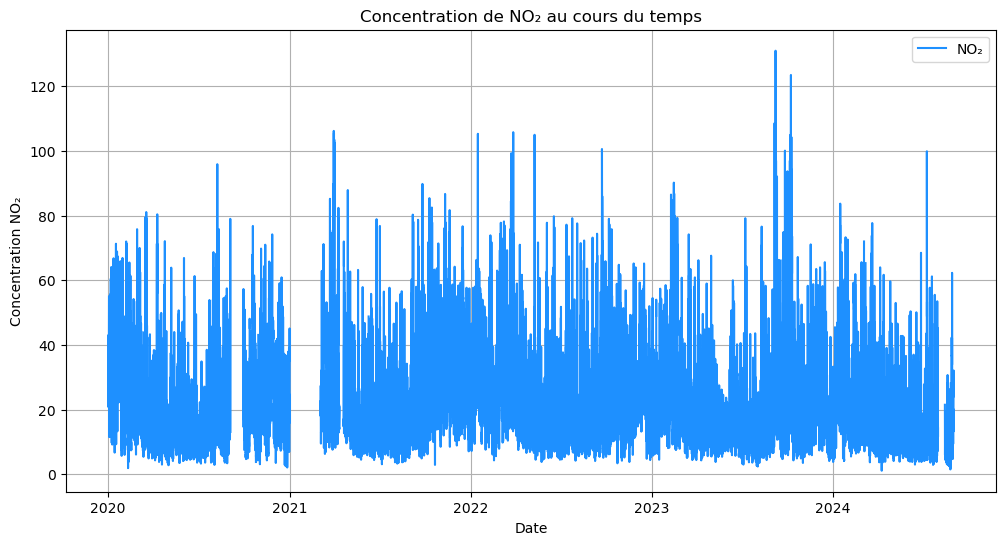

In [40]:
# Tracer la série temporelle de NO₂
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['valeur_NO2'], label='NO₂', color='dodgerblue')
plt.title('Concentration de NO₂ au cours du temps')
plt.xlabel('Date')
plt.ylabel('Concentration NO₂')
plt.legend()
plt.grid(True)
plt.show()

In [60]:
# Set the different imputers
imputer_mean = imputers.ImputerSimple(strategy="median")
imputer_interpol = imputers.ImputerInterpolation(method="linear")
imputer_var1 = imputers.ImputerEM(model="VAR", method="mle", max_iter_em=50, n_iter_ou=15, dt=1e-3, p=1)

dict_imputers = {
    "mean": imputer_mean,
    "interpolation": imputer_interpol,
    "VAR(1) process": imputer_var1}

In [61]:
valeur_NO2_imp = imputer_interpol.fit_transform(df['valeur_NO2'].values.reshape(-1, 1))

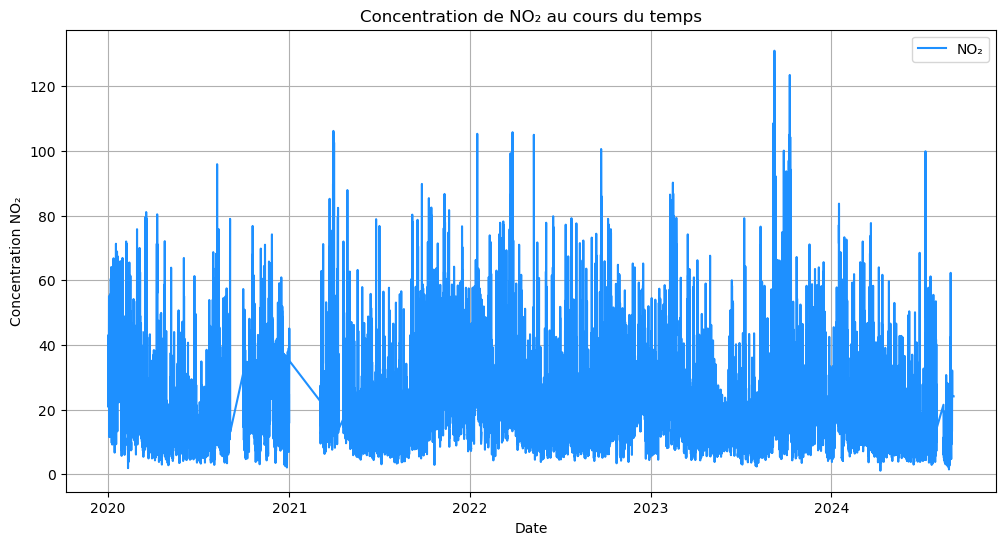

In [62]:
# Tracer la série temporelle de NO₂
plt.figure(figsize=(12, 6))
plt.plot(df.index, valeur_NO2_imp, label='NO₂', color='dodgerblue')
plt.title('Concentration de NO₂ au cours du temps')
plt.xlabel('Date')
plt.ylabel('Concentration NO₂')
plt.legend()
plt.grid(True)
plt.show()

Ici globalement Simple c'est merdique, VAR(1) aussi mais comprendre pourquoi (ça fait juste du flat), et interpol ça fait linéaire mais vraiment pas top.

### Test de nouveaux interpoler

In [63]:
from sklearn.linear_model import LinearRegression

In [64]:
imputer_median = imputers.ImputerSimple(strategy="median")
imputer_interpol = imputers.ImputerInterpolation(method="linear")
imputer_residuals = imputers.ImputerResiduals(
    period=365,
    model_tsa="additive",
    extrapolate_trend="freq",
    method_interpolation="linear",
)
imputer_tsou = imputers.ImputerEM(
    model="VAR",
    method="sample",
    max_iter_em=30,
    n_iter_ou=15,
    dt=1e-3,
    p=1,
)
imputer_mice = imputers.ImputerMICE(
    estimator=LinearRegression(),
    sample_posterior=False,
    max_iter=100,
)


dict_imputers = {
    "median": imputer_median,
    "interpolation": imputer_interpol,
    "residuals": imputer_residuals,
    "TSOU": imputer_tsou,
    "mice": imputer_mice,
}
n_imputers = len(dict_imputers)

In [71]:
valeur_NO2_imp = imputer_tsou.fit_transform(df['valeur_NO2'].values.reshape(-1, 1))

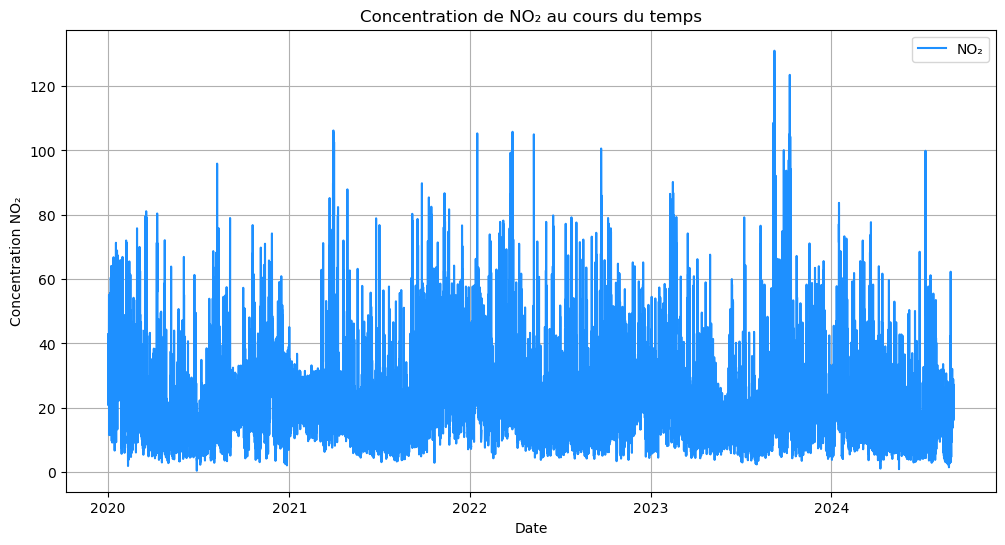

In [72]:
# Tracer la série temporelle de NO₂
plt.figure(figsize=(12, 6))
plt.plot(df.index, valeur_NO2_imp, label='NO₂', color='dodgerblue')
plt.title('Concentration de NO₂ au cours du temps')
plt.xlabel('Date')
plt.ylabel('Concentration NO₂')
plt.legend()
plt.grid(True)
plt.show()

Tsou ça a l'air pas mal mais faudrait faire un vrai benchmark sur nos valeurs.

In [95]:
# Essayer de trouver un segment sur lequel il n'y a pas de valeurs manquantes (ou très peu)
df['valeur_NO2'].iloc[16000:20000].isna().sum()

4

In [81]:
df.shape[0]

40991

Essayer de faire le test Time Series sur notre dataset:

In [96]:
import numpy as np
import pandas as pd

np.random.seed(1234)
from matplotlib import pyplot as plt
import matplotlib.ticker as plticker

tab10 = plt.get_cmap("tab10")

from qolmat.benchmark import comparator, missing_patterns
from qolmat.imputations import imputers
from qolmat.utils import data, plot
from sklearn.linear_model import LinearRegression

In [116]:
df

,valeur_NO2,valeur_CO,valeur_O3,valeur_PM10,valeur_PM25
date_time,,,,,
2020-01-01 00:00:00,42.9,0.718,15.7,73.1,64.4
2020-01-01 01:00:00,33.6,0.587,10.1,74.8,66.0
2020-01-01 02:00:00,29.3,NaN,5.1,51.0,44.9
2020-01-01 03:00:00,30.5,0.246,7.2,27.7,25.1
2020-01-01 04:00:00,29.3,0.204,8.3,15.3,13.6
...,...,...,...,...,...
2024-09-03 18:00:00,NaN,0.222,55.1,12.0,5.3
2024-09-03 19:00:00,NaN,0.245,48.2,13.4,7.0
2024-09-03 20:00:00,NaN,0.234,44.5,12.4,7.1


In [197]:
# Tester seulement sur 1000 valeurs pour l'instant pour computation time
df_data = df_1[["valeur_NO2", "valeur_CO", "valeur_O3", "valeur_PM10", "valeur_PM25"]].iloc[29000:30000]
cols_to_impute = ["valeur_NO2", "valeur_CO", "valeur_O3", "valeur_PM10", "valeur_PM25"]
df = data.add_holes(df_data, ratio_masked=0.15, mean_size=50)

In [198]:
df_data.isnull().sum()

valeur_NO2      18
valeur_CO       21
valeur_O3       18
valeur_PM10    181
valeur_PM25     18
dtype: int64

In [199]:
df.isnull().sum()

valeur_NO2     168
valeur_CO      171
valeur_O3      168
valeur_PM10    331
valeur_PM25    168
dtype: int64

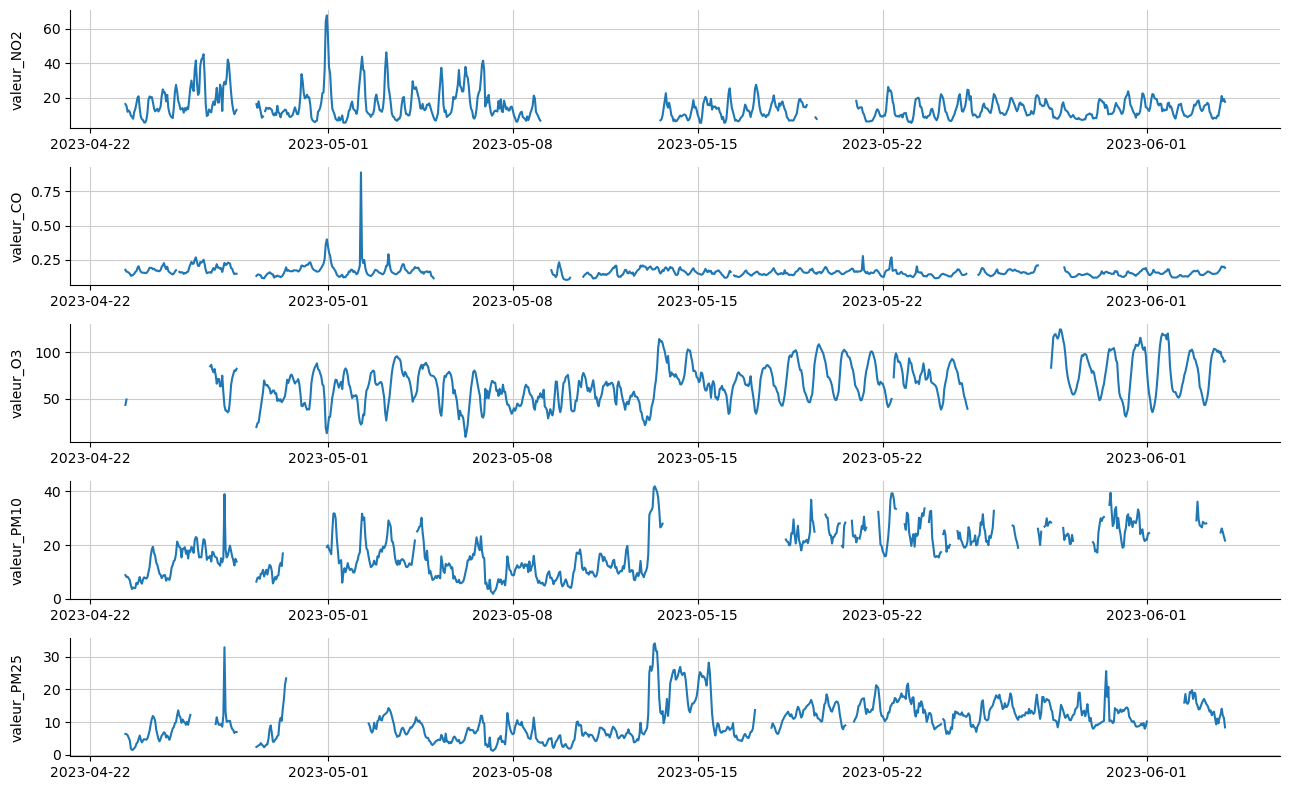

In [200]:
fig, ax = plt.subplots(len(cols_to_impute), 1, figsize=(13, 8))
for i, col in enumerate(cols_to_impute):
    ax[i].plot(df.loc[:, col])
    ax[i].set_ylabel(col)
fig.align_labels()
plt.tight_layout()
plt.show()

In [201]:
ratio_masked = 0.1

imputer_median = imputers.ImputerSimple(strategy="mean")
imputer_interpol = imputers.ImputerInterpolation(method="linear")
imputer_residuals = imputers.ImputerResiduals(
    period=365,
    model_tsa="additive",
    extrapolate_trend="freq",
    method_interpolation="linear",
)
imputer_tsou = imputers.ImputerEM(
    model="VAR",
    method="sample",
    max_iter_em=30,
    n_iter_ou=15,
    dt=1e-3,
    p=1,
)
imputer_mice = imputers.ImputerMICE(
    estimator=LinearRegression(),
    sample_posterior=False,
    max_iter=100,
)

generator_holes = missing_patterns.EmpiricalHoleGenerator(
    n_splits=4, subset=cols_to_impute, ratio_masked=ratio_masked
)

dict_imputers = {
    "median": imputer_median,
    "interpolation": imputer_interpol,
    "residuals": imputer_residuals,
    "TSOU": imputer_tsou,
    "mice": imputer_mice,
}
n_imputers = len(dict_imputers)

In [202]:
comparison = comparator.Comparator(
    dict_imputers,
    cols_to_impute,
    generator_holes=generator_holes,
    metrics=["mae", "wmape", "KL_columnwise", "wasserstein_columnwise"],
    max_evals=5,
)

In [203]:
results = comparison.compare(df)
results.style.highlight_min(color="lightsteelblue", axis=1)

Testing model: median...done.
Testing model: interpolation...done.
Testing model: residuals...done.
Testing model: TSOU...done.
Testing model: mice...done.


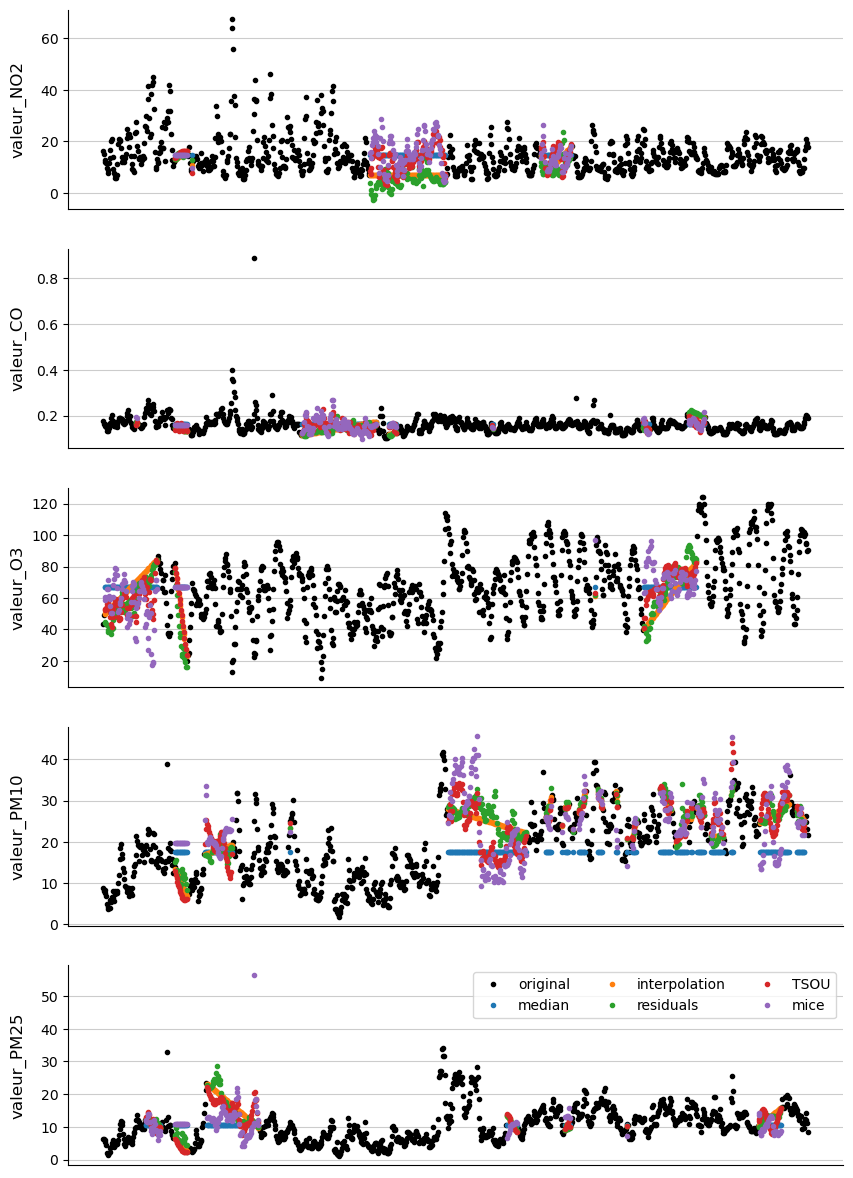

In [206]:
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import numpy as np

# Suppose que df_plot contient toutes les données sans regroupement par station
df_plot = df[cols_to_impute]
# Imputation des valeurs manquantes pour chaque modèle
dfs_imputed = {name: imp.fit_transform(df_plot) for name, imp in dict_imputers.items()}

# Au lieu de sélectionner une station, tu prends l'ensemble de df_plot
fig, axs = plt.subplots(len(cols_to_impute), 1, sharex=True, figsize=(10, 3 * len(cols_to_impute)))

# Boucle à travers chaque colonne et chaque axe pour tracer les valeurs
for col, ax in zip(cols_to_impute, axs.flatten()):
    values_orig = df_plot[col]
    ax.plot(values_orig, ".", color="black", label="original")
    
    # Tracer les valeurs imputées pour chaque méthode
    for ind, (name, model) in enumerate(list(dict_imputers.items())):
        values_imp = dfs_imputed[name][col].copy()  # Utiliser les données imputées
        values_imp[values_orig.notna()] = np.nan  # Ne pas montrer les valeurs originales
        ax.plot(values_imp, ".", color=tab10(ind), label=name, alpha=1)  # Tracer les valeurs imputées

    ax.set_ylabel(col, fontsize=12)
    
# Ajouter une légende et ajuster l'axe des ticks
ax.legend(fontsize=10, ncol=3)
ax.tick_params(axis="both", which="major", labelsize=10)

# Ajuster l'axe x pour afficher des ticks à intervalle régulier (par exemple, 365 jours)
loc = plticker.MultipleLocator(base=365)
ax.xaxis.set_major_locator(loc)

fig.align_labels()
plt.show()


In [215]:
# Tester TSOU entre MLE et SAMPLE
ratio_masked = 0.1

imputer_tsou_sample = imputers.ImputerEM(
    model="VAR",
    method="sample",
    max_iter_em=30,
    n_iter_ou=15,
    dt=1e-3,
    p=1,
)

imputer_tsou_mle = imputers.ImputerEM(
    model="VAR",
    method="mle",
    max_iter_em=30,
    n_iter_ou=15,
    dt=1e-3,
    p=1,
)
generator_holes = missing_patterns.EmpiricalHoleGenerator(
    n_splits=4, subset=cols_to_impute, ratio_masked=ratio_masked
)

dict_imputers = {
    "TSOU_sample": imputer_tsou_sample,
    "TSOU_mle": imputer_tsou_mle
}
n_imputers = len(dict_imputers)

In [216]:
comparison = comparator.Comparator(
    dict_imputers,
    cols_to_impute,
    generator_holes=generator_holes,
    metrics=["mae", "wmape", "KL_columnwise", "wasserstein_columnwise"],
    max_evals=5,
)

In [220]:
results = comparison.compare(df)
results.style.highlight_min(color="lightsteelblue", axis=1)

Testing model: TSOU_sample...done.
Testing model: TSOU_mle...done.


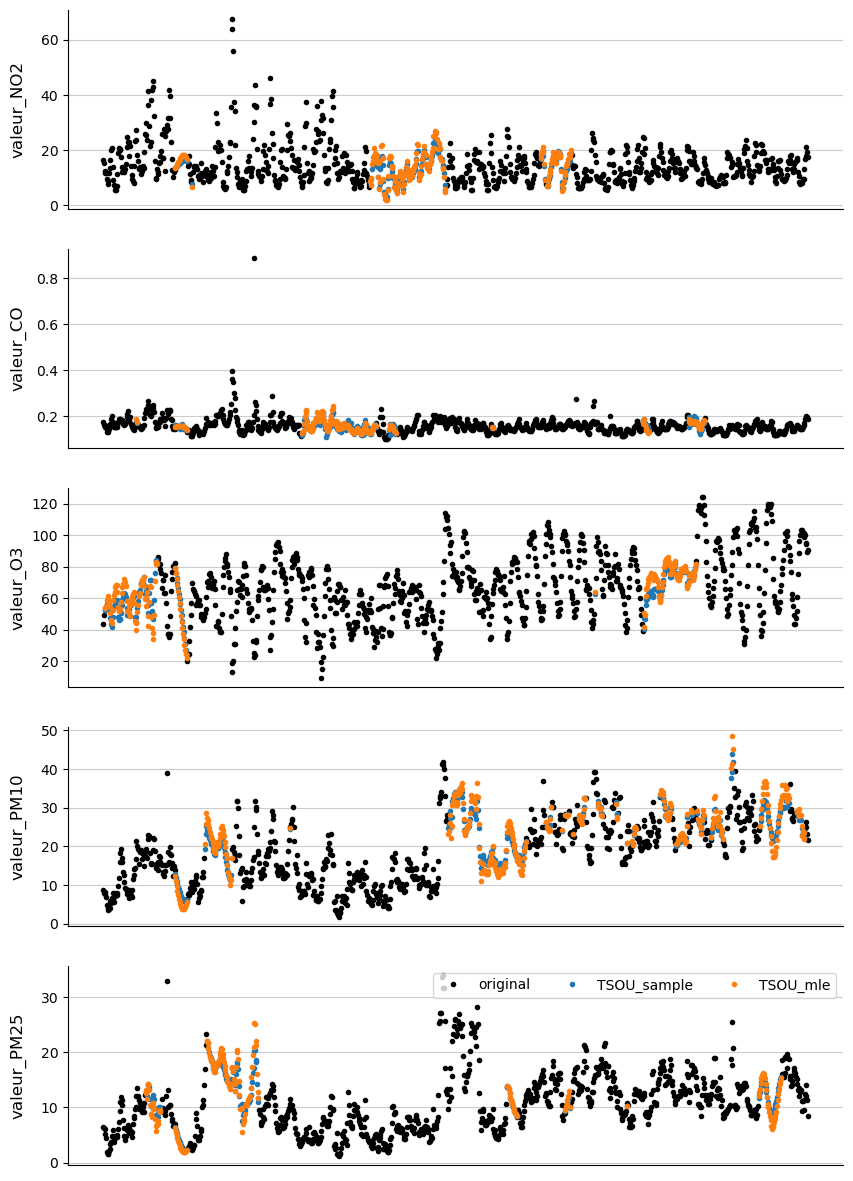

In [221]:

# Suppose que df_plot contient toutes les données sans regroupement par station
df_plot = df[cols_to_impute]
# Imputation des valeurs manquantes pour chaque modèle
dfs_imputed = {name: imp.fit_transform(df_plot) for name, imp in dict_imputers.items()}

# Au lieu de sélectionner une station, tu prends l'ensemble de df_plot
fig, axs = plt.subplots(len(cols_to_impute), 1, sharex=True, figsize=(10, 3 * len(cols_to_impute)))

# Boucle à travers chaque colonne et chaque axe pour tracer les valeurs
for col, ax in zip(cols_to_impute, axs.flatten()):
    values_orig = df_plot[col]
    ax.plot(values_orig, ".", color="black", label="original")
    
    # Tracer les valeurs imputées pour chaque méthode
    for ind, (name, model) in enumerate(list(dict_imputers.items())):
        values_imp = dfs_imputed[name][col].copy()  # Utiliser les données imputées
        values_imp[values_orig.notna()] = np.nan  # Ne pas montrer les valeurs originales
        ax.plot(values_imp, ".", color=tab10(ind), label=name, alpha=1)  # Tracer les valeurs imputées

    ax.set_ylabel(col, fontsize=12)
    
# Ajouter une légende et ajuster l'axe des ticks
ax.legend(fontsize=10, ncol=3)
ax.tick_params(axis="both", which="major", labelsize=10)

# Ajuster l'axe x pour afficher des ticks à intervalle régulier (par exemple, 365 jours)
loc = plticker.MultipleLocator(base=365)
ax.xaxis.set_major_locator(loc)

fig.align_labels()
plt.show()

Ok so MLE Seems better.

In [ ]:
# Faudrait aussi comprendre MICE et pourquoi on prend LinearRegression

Ok donc prenons TSOU.

In [228]:
from utils.preprocessing import Imputer_TSOU

df_imputed_1 = Imputer_TSOU(df_1)


In [224]:
df_1.isna().sum()   

valeur_NO2      3297
valeur_CO      12529
valeur_O3        693
valeur_PM10     7167
valeur_PM25     1791
dtype: int64

In [ ]:
df_imputed_1.isna().sum()   

valeur_NO2      3297
valeur_CO      12529
valeur_O3        693
valeur_PM10     7167
valeur_PM25     1791
dtype: int64